## EMR Studio - Dependencies
Many of these are already installed (like matplotlib and numpy), but keeping them here for documentation purposes.

For matplotlib, it was installed using an EMR Step that installed `basemap` along with corresponding OS dependencies (like `geos`).

In [7]:
pip install matplotlib boto3 xarray==0.17.0 netCDF4 zarr==2.5.0 fsspec s3fs numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Example data
Let's take a quick look at what our weather data looks like - first, we'll peek at precipitation zarr.

In [8]:
import xarray as xr
import numpy as np

# xarray 0.17.0 requires consolidated=True for this particular dataset
xr.open_zarr(
    "s3://era5-pds/zarr/2020/12/data/precipitation_amount_1hour_Accumulation.zarr/",
    consolidated=True,
)

<xarray.Dataset>
Dimensions:                                  (lat: 721, lon: 1440, nv: 2, time1: 744)
Coordinates:
  * lat                                      (lat) float32 90.0 89.75 ... -90.0
  * lon                                      (lon) float32 0.0 0.25 ... 359.8
  * time1                                    (time1) datetime64[ns] 2020-12-0...
Dimensions without coordinates: nv
Data variables:
    precipitation_amount_1hour_Accumulation  (time1, lat, lon) float32 ...
    time1_bounds                             (time1, nv) datetime64[ns] ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

## Build a map of weather data for a given day

This demo showcases the EMR Studio notebook environment. We'll use a combination of input parameters, [ERA5 Zarr data](https://registry.opendata.aws/ecmwf-era5/) available on the [Registry of Open Data on AWS](https://registry.opendata.aws), and `matplotlib` to build a map of what the weather was in the US for any given day since 1979.

Below we'll define our input parameters (ISO date - 2021-01-13) and a handy function for converting that date string to a more human-readable one.

And then we define a couple functions for fetching our zarr data.
- `open_zarrs` specifies the 3 datasets we want to retrieve
- `get_zarr_for_date` returns the actual zarr data from S3 for a specific Y-m-d

In [3]:
# This cell has a `parameter` tag so we can override it in workflows
# ref: https://papermill.readthedocs.io/en/latest/usage-parameterize.html#id1
weather_date = '2020-01-13'

In [4]:
from datetime import datetime

def date_string_to_human(ymd):
    d = datetime.strptime(ymd, '%Y-%m-%d')
    return d.strftime("%B %d, %Y")

In [5]:
import xarray as xr
import numpy as np


def get_zarr_for_date(measure, ymd):
    year = ymd.split('-')[0]
    month = ymd.split('-')[1]
    time_slice = slice(
        np.datetime64(ymd),
        np.datetime64(f"{ymd} 23:59")
    )
    zarr_prefix = f"era5-pds/zarr/{year}/{month}/data/{measure}.zarr"
    remote_data = xr.open_zarr(
        f"s3://{zarr_prefix}/",
        consolidated=True,
    )
    # precipitation zarr has a different time dimension name (time1 vs. time0 for the others)
    time_key = list(remote_data.filter_by_attrs(standard_name="time").to_dict()['dims'].keys())[0]
    return remote_data.sel({time_key: time_slice})

def open_zarrs(ymd):
    zarr_measures = ['air_pressure_at_mean_sea_level', 'air_temperature_at_2_metres', 'precipitation_amount_1hour_Accumulation']
    return [get_zarr_for_date(m, ymd) for m in zarr_measures]

In [6]:
pressure, temp, precip = open_zarrs(weather_date)

In [7]:
precip_data = precip.precipitation_amount_1hour_Accumulation[12,:,:].values

pressure_data = pressure.air_pressure_at_mean_sea_level[12,:,:].values
pressure_data = pressure_data * 0.01 # Pa to hPa

temp_data = temp.air_temperature_at_2_metres[12,:,:].values
temp_data =  (temp_data - 273.15) * 9/5 + 32.0 # K to F

lons, lats = np.meshgrid(temp.lon.values, temp.lat.values)

Unfortunately, due to the way basemap (which is now deprecated, but many folks still use it) is installed, we need to inject an environment variable before importing.

In [8]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

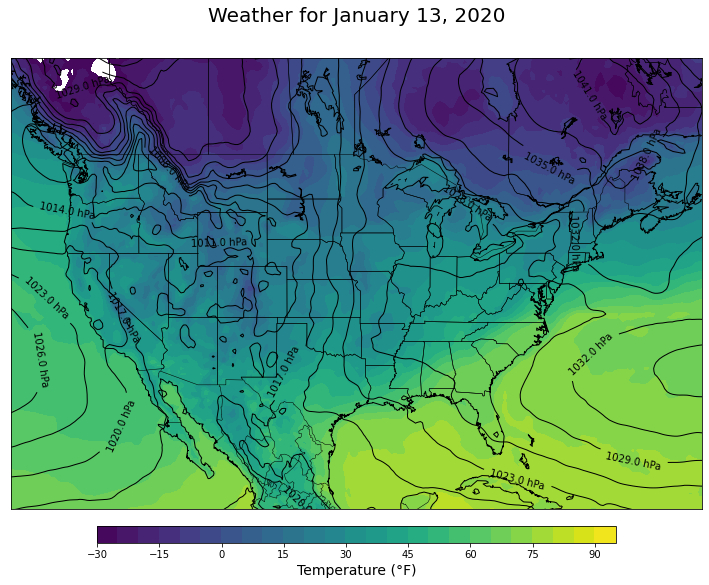

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(llcrnrlon = 230., llcrnrlat = 20., urcrnrlon = 300., urcrnrlat = 55., resolution = 'l', projection = 'merc', ax = ax)

x, y = m(lons, lats)

# Plot Temperature data
clevs = np.arange(-30, 100, 5.)
t_c = m.contourf(x, y, temp_data, clevs)

# Plot MSLP contours every 3 hPa
clevs = np.arange(900, 1100., 3.)
mslp_c = m.contour(x, y, pressure_data, clevs, colors='k', linewidths=1.)
plt.clabel(mslp_c, mslp_c.levels, inline=True, fmt='%r hPa', fontsize=10)

# Give ourselves some context
m.drawcoastlines()
m.drawstates()
m.drawcountries()

cbax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=plt.colorbar(mappable=t_c, cax=cbax, orientation='horizontal')
cbar.set_label('Temperature (°F)', fontsize=14)
plt.suptitle(f'Weather for {date_string_to_human(weather_date)}', fontsize=20)
plt.show()